# Milestone 3: Model Training and Evaluation with PyTorch Lightning

Welcome to Milestone 3 of LIS 640 – Introduction to Applied Deep Learning. In this milestone, you'll build upon your work from Milestones 1 and 2 by upgrading your neural network baseline to a more robust training framework using PyTorch Lightning and TensorBoard logging. You will also be exploring the advantages of different neural architectures (recurrent and convolutional neural networks) and different optimizers.

## Purpose

The goal of Milestone 3 is to:
- **Explore advanced architectures:** The main goal of Milestone 3 is to strengthen your knowledge about and experience with popular neural architectures including convolutional neural networks (CNNs) and recurrent neural networks (RNNs).
- **Streamline your model development:** Make sure you are working with easy-to-maintain Lightning modules.
- **Enhance experiment tracking:** Integrate TensorBoard to log and visualize training metrics, making it easier to monitor performance and debug issues.
- **Investigate optimizer effects:** Experiment with different optimizers (such as Adam, SGD, and RMSprop) to understand their impact on model training and performance.


## Part 1: Benchmarking Feedforward NN vs. RNN on Sequence Data

In this step, you'll compare the performance of a Recurrent Neural Network (RNN) against a Feedforward Neural Network (FFNN) on a dataset that contains sequential data. **For this exercise, you must use PyTorch Lightning to build your models and manage the training loop, as well as TensorBoard for logging and visualizing your training metrics.**

### A. Choose Your Dataset

- **Option 1:**  
  Use one of the datasets from Milestone 1 **if it contains sequence data**.  
  *For example, if your dataset involves time series, text, or any ordered data, it qualifies for this comparison.* In that case you have already done part B and can skip on to part C.

- **Option 2:**  
  If your Milestone 1 dataset does not include sequence data, search online for and download a dataset that features sequential information (e.g., time series forecasting, text classification, sensor data, etc.). Take inspiration from previous milestones on how to do part B (Data Preparation) for your new dataset.

### B. Data Preparation

1. **Create a Custom Dataset Class:**  
   - Implement a PyTorch `Dataset` class that loads your sequence data.
   - Include any necessary preprocessing steps (e.g., normalization, tokenization, padding for sequences).
   - Ensure that your `__getitem__` method returns the data in a format suitable for your models.

2. **Build DataLoaders:**  
   - Use `torch.utils.data.DataLoader` to create train, validation, and test loaders.
   - Choose appropriate batch sizes and shuffling to ensure effective training.

### C. Model Implementation with PyTorch Lightning

*Reuse implementations from Milestone 2 if that makes sense. The key difference now is that you should implement your models as PyTorch Lightning modules to take advantage of the built-in training loop and logging features.*

1. **Feedforward Neural Network (FFNN):**  
   - Implement a baseline feedforward network that treats the sequence data as independent features (e.g., by flattening the sequence).
   - Keep the architecture simple to establish a baseline for comparison.

2. **Recurrent Neural Network (RNN):**  
   - Implement an RNN model (using LSTM or GRU) to handle the sequential nature of the data.
   - Ensure that your model processes the sequence appropriately (e.g., using the final hidden state or an attention mechanism for prediction).

*Remember to use the PyTorch Lightning `Trainer` for model training, and configure the module to log metrics to TensorBoard.*

### D. Benchmarking and Evaluation

1. **Training Both Models:**  
   - Train both the FFNN and the RNN on your chosen dataset using similar training settings (e.g., number of epochs, learning rate, optimizer) to ensure a fair comparison.
   - Use PyTorch Lightning’s `Trainer` to manage the training process.

2. **Logging and Evaluation Metrics:**  
   - Leverage TensorBoard logging to visualize training and validation metrics in real-time.
   - Compare the performance of both models using metrics such as loss, accuracy, or any task-specific metric.
   - Optionally, record additional statistics like training time or convergence behavior.

3. **Document Your Findings:**  
   - Summarize the dataset and preprocessing steps.
   - Describe the architectures used for the FFNN and RNN.
   - Provide a comparative analysis discussing which model performed better and why that might be the case.
   - Include TensorBoard screenshots or logged results to support your analysis.

In [1]:
# making word embeddings for rnn training
from transformers import BertTokenizer, BertModel
import torch 
import torch.nn as nn
import pandas as pd
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
import tensorboard


c:\Users\likua\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:

# loading BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# reading csv file 
corpus = pd.read_csv(r"D:\Applied Deep Learning\data\combined_DF_new\combined_new_df.csv")

max_length = 128  
batch_size = 16  
#make data into batch of 16, and max length of 128

# make bert embeddings
def encode_text(text):
    encoding = tokenizer(text, padding='max_length', truncation=True, max_length=max_length, return_tensors='pt')
    return encoding['input_ids'][0], encoding['attention_mask'][0]

# convert all the texts into embeddings
input_ids, attention_masks = zip(*corpus['text'].map(encode_text))
input_ids = torch.stack(input_ids)           # shape: [num_samples, seq_len]
attention_masks = torch.stack(attention_masks) # shape: [num_samples, seq_len]

# building DataLoader
dataset = TensorDataset(input_ids, attention_masks)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)


In [4]:
all_embeddings = []

with torch.no_grad():
    for batch in dataloader:
        batch_input_ids, batch_attention_mask = batch
        outputs = bert_model(batch_input_ids, attention_mask=batch_attention_mask)
        # outputs.last_hidden_state: [batch_size, seq_len, 768]
        all_embeddings.append(outputs.last_hidden_state)

# combine all of the batches to get full embeddings
# NOTE：shape of all_embeddings [num_samples, seq_len, 768]
all_embeddings = torch.cat(all_embeddings, dim=0)
print("Embeddings shape:", all_embeddings.shape)

Embeddings shape: torch.Size([5124, 128, 768])


# DATA SUMMARY
Here, I still used the text dataset for embedding. As the data I am dealing with is text data, building up a time sequence for the tokens are necessary. THerefore, I set up the length for a time sequential data as 128 tokens for the embedding pattern learning (it was 512 at first but the memory exploded). Then. the embedding data were distributed in a form of this: [number of samples, length of tokens numbers for each sequential sample, word embedding demensions]. This data structure is suitable to feed to RNN model because it eaxmines sequential data. But when I am dealing with MLP, it can not work with sequential data, so I used mean(dim=1) to make the data look like this:[number of samples, word embedding demensions] 

In [ ]:
class RNNClassifier(nn.Module):
    def __init__(self, input_size=768, hidden_size=128, num_classes=2):
        super(RNNClassifier, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)# lstm is used here because it is more suitable for sequential data

        self.fc = nn.Linear(hidden_size, num_classes)# linear layer to map the hidden state to the number of classes
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        _, (hidden, _) = self.lstm(x)  # only need the last hidden state
        out = self.fc(hidden[-1])  # feeding the last hidden state to the classifier

        return self.softmax(out)  # use softmax for multi-class classification


# building up the model
model = RNNClassifier()

In [9]:
#use lightning to store and evaluate the model
class RNNClassifierLightning(pl.LightningModule):
    def __init__(self, input_size=768, hidden_size=128, num_classes=2, lr=0.001):
        super(RNNClassifierLightning, self).__init__()

        self.model = RNNClassifier(input_size, hidden_size, num_classes)
        
        self.lr = lr

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = nn.CrossEntropyLoss()(y_hat, y)
        self.log('val_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('val_acc', (y_hat.argmax(dim=1) == y).float().mean(), on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)
logger = TensorBoardLogger('logs/', name='rnn_classifier')

x_embeddings = torch.tensor(all_embeddings).float()  # convert to float tensor
y_labels = torch.tensor(corpus['label'].values)  # convert to tensor

LightningModel = RNNClassifierLightning()
train_dataset = TensorDataset(x_embeddings, y_labels)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
trainer = pl.Trainer(max_epochs=20,accelerator='auto',logger=logger)  # use GPU if available
trainer.fit(LightningModel, train_dataloader)
# Save the model
trainer.save_checkpoint(r"C:\Users\likua\OneDrive\Desktop\Model\rnn_classifier.ckpt")


C:\Users\likua\AppData\Local\Temp\ipykernel_3548\1611909435.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_embeddings = torch.tensor(all_embeddings).float()  # convert to float tensor
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | RNNClassifier | 46

Epoch 19: 100%|██████████| 321/321 [00:01<00:00, 163.80it/s, v_num=2, val_loss_step=0.563, val_acc_step=0.750, val_loss_epoch=0.395, val_acc_epoch=0.917]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 321/321 [00:01<00:00, 161.65it/s, v_num=2, val_loss_step=0.563, val_acc_step=0.750, val_loss_epoch=0.395, val_acc_epoch=0.917]


In [48]:
import os
print(os.listdir("logs/RNN_classifier"))
print(os.listdir('logs/RNN_classifier/version_0/checkpoints'))
print("Logs directory:", os.path.abspath('logs/RNN_classifier'))

['version_0', 'version_1']
['epoch=19-step=6420.ckpt']
Logs directory: d:\Applied Deep Learning\logs\RNN_classifier


# Model Summary -- RNN
In this model class, I build up the model by using LSTM-- which is common among NLP tasks( I will use transformers everntually). Then, linear layer is used to map the tensors from 128 neurons to 2 numbers of classifications. Finally, softmax was used to convert the output to probabilities: Is the time sequential produced by "English natives"? Or it is made by Japanese?  Then, torch lightning has been used for model training and evaluation: not only did I used lightning, but also used logging for metrics evaluation-- learning about validation set loss and accuracy, in the end, I tried to store it in a .ckpt file as a practice of future use.

In [8]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

x_train = torch.tensor(all_embeddings, dtype=torch.float32)  # shape: (num_samples, seq_len, embedding_dim)
print("x_train shape:", x_train.shape)

y_train = torch.tensor(corpus['label'].values, dtype=torch.long)  # shape: (num_samples,)
y_train = y_train.squeeze()
print("y_train shape:", y_train.shape)

batch_size = 4
dataloader = DataLoader(TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0
    
    for batch_x, batch_y in dataloader:
        optimizer.zero_grad()
        
        batch_x = batch_x.to(torch.float32)
        batch_y = batch_y.to(torch.long)
        
        outputs = model(batch_x)  # the outpur would be (batch_size, seq_len, num_classes)
        if outputs.dim() == 3:
            outputs = outputs[:, -1, :]  # retrive the last time step output
        
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        # accuracy calculation: the output of the model is (batch_size, num_classes), and the label is (batch_size,)
        _, predicted = torch.max(outputs, dim=1)
        total_correct += (predicted == batch_y).sum().item()
        total_samples += batch_y.size(0)
    
    avg_loss = total_loss / len(dataloader)
    accuracy = total_correct / total_samples
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")

    





C:\Users\likua\AppData\Local\Temp\ipykernel_24980\2101745372.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(all_embeddings, dtype=torch.float32)  # shape: (num_samples, seq_len, embedding_dim)


x_train shape: torch.Size([5124, 128, 768])
y_train shape: torch.Size([5124])
Epoch 1, Loss: 0.5076, Accuracy: 0.8002
Epoch 2, Loss: 0.4877, Accuracy: 0.8160
Epoch 3, Loss: 0.4708, Accuracy: 0.8372
Epoch 4, Loss: 0.4575, Accuracy: 0.8525
Epoch 5, Loss: 0.4505, Accuracy: 0.8583
Epoch 6, Loss: 0.4457, Accuracy: 0.8610
Epoch 7, Loss: 0.4384, Accuracy: 0.8714
Epoch 8, Loss: 0.4315, Accuracy: 0.8765
Epoch 9, Loss: 0.4245, Accuracy: 0.8860
Epoch 10, Loss: 0.4224, Accuracy: 0.8874
Epoch 11, Loss: 0.4199, Accuracy: 0.8915
Epoch 12, Loss: 0.4177, Accuracy: 0.8915
Epoch 13, Loss: 0.4151, Accuracy: 0.8964
Epoch 14, Loss: 0.4074, Accuracy: 0.9028
Epoch 15, Loss: 0.4050, Accuracy: 0.9059
Epoch 16, Loss: 0.4050, Accuracy: 0.9063
Epoch 17, Loss: 0.4052, Accuracy: 0.9055
Epoch 18, Loss: 0.4018, Accuracy: 0.9104
Epoch 19, Loss: 0.3971, Accuracy: 0.9155
Epoch 20, Loss: 0.3969, Accuracy: 0.9143


Comparing it with MLP (FFNN)

The following are the code for MLP

In [50]:
# dfining MLP module class
class MLP(nn.Module):
    def __init__(self, input_size=768, hidden_size=128, num_classes=2):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
        self.softmax = nn.Softmax(dim=1) #do not use softmax here, because it is used in the loss function

    def forward(self, x):
        x=x.mean(dim=1)# the shape of x was  (batch_size, seq_len, embedding_dim),but now[4,768]
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x  # use softmax for multi-class classification
logger = TensorBoardLogger('logs/', name='MLP_classifier')
    

    
    
# building up the model
model = MLP()   


In [51]:
y_labels = torch.tensor(corpus['label'].values).long()
print("Original y_labels shape:", y_labels.shape)
y_labels = y_labels.squeeze()
print("After squeeze, y_labels shape:", y_labels.shape)


Original y_labels shape: torch.Size([5124])
After squeeze, y_labels shape: torch.Size([5124])


In [59]:
# use lightning to store and evaluate the model
class MLPClassifierLightning(pl.LightningModule):
    def __init__(self, input_size=768, hidden_size=128, num_classes=2, lr=0.001):
        super(MLPClassifierLightning, self).__init__()

        self.model = MLP(input_size, hidden_size, num_classes)
        self.lr = lr

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = nn.CrossEntropyLoss()(y_hat, y)# we use the same loss here for fair comparison
        acc= (y_hat.argmax(dim=1) == y).float().mean()
        self.log('val_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('val_acc', acc, on_step=True, on_epoch=True, prog_bar=True)
        
        
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)
    
x_embeddings = torch.tensor(all_embeddings).float()  # convert to float tensor
y_labels = torch.tensor(corpus['label'].values).long().squeeze()
  # convert to tensor, we need to make sure the label is long tensor

train_dataset = TensorDataset(x_embeddings, y_labels)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
LightningModel = MLPClassifierLightning()
trainer = pl.Trainer(max_epochs=20, accelerator='auto',logger=logger)  # use GPU if available, DO remember to set the logger here, or it will not work
trainer.fit(LightningModel, train_dataloader)
# Save the model
trainer.save_checkpoint(r"C:\Users\likua\OneDrive\Desktop\Model\mlp_classifier.ckpt")

    

C:\Users\likua\AppData\Local\Temp\ipykernel_25060\704573453.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_embeddings = torch.tensor(all_embeddings).float()  # convert to float tensor
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params | Mode 
---------------------------------------
0 | model | MLP  | 98.7 K | train
---------------------------------------
98.7 K    Trainable params
0         Non-trainable params
98.7 K    Total params
0.395     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode
c:\Users\likua\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' 

Epoch 19: 100%|██████████| 321/321 [00:01<00:00, 196.64it/s, v_num=0, val_loss_step=0.530, val_acc_step=0.750, val_loss_epoch=0.276, val_acc_epoch=0.873] 

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 321/321 [00:01<00:00, 195.46it/s, v_num=0, val_loss_step=0.530, val_acc_step=0.750, val_loss_epoch=0.276, val_acc_epoch=0.873]


In [60]:
print(os.listdir("logs/MLP_classifier"))
print(os.listdir('logs/MLP_classifier/version_0/checkpoints'))
print("Logs directory:", os.path.abspath('logs/MLP_classifier'))

['version_0']
['epoch=19-step=6420.ckpt']
Logs directory: d:\Applied Deep Learning\logs\MLP_classifier


# MLP
Same procedure as RNN but the structure of the model is: Linear, ReLU and Linear, and the data I fed to MLP is different from RNN -- as it can not work with sequential tagged tensors. 

RNN performance:186.54it/s, v_num=19, val_loss_step=0.316, val_acc_step=1.000, val_loss_epoch=0.387, val_acc_epoch=0.926

MLP(FFNN) performance: 258.25it/s, v_num=16, val_loss_step=0.233, val_acc_step=1.000, val_loss_epoch=0.278, val_acc_epoch=0.870

In this model training session, I setted up learning rate = 0.001, traning epochs=20, loss type as Crossentropy loss, optimizer as Adam.  Both models are trained busing the same parameter. For RNN, I set up the length of sentence as 128 to capture time sequence pattern in BERT embedding while when I am training MLP, I used mean(dim=1) to make the tensor into 1 demension to fit into the shape of MLP(without sequential processing)

Performance:
For RNN model, the traninig speed is 186.54 it/s while MLP model speed is 258.25it/s, MLP model is faster.
For the validation set loss, RNN is 0.387 while MLP is 0.278. There is lower loss for MLP.
But look at the validation set accuracy: the accuracy for RNN is 0.926 while the accuracy for MLP is 0.870. This means that when computation resource is allowed, RNN would perform better in accuracy, and it is a giant leap in terms of accuracy in prediction. 


## Part 3: Benchmarking Feedforward NN vs. CNN on Image Data

In this step, you'll compare the performance of a Convolutional Neural Network (CNN) against a Feedforward Neural Network (FFNN) on an image-based dataset. **For this exercise, you must use PyTorch Lightning to implement your models and manage training, and use TensorBoard for logging and visualizing your training metrics.**

### A. Choose Your Dataset

- **Option 1:**  
  Use one of the datasets from Milestone 1 **if it contains image data**.  
  *For example, if your dataset involves images for classification, segmentation, or any visual task, it qualifies for this comparison.*

- **Option 2:**  
  If your Milestone 1 dataset does not include image data, search online for and download an image dataset (e.g., Fashion MNIST, CIFAR-10, or any domain-specific image dataset).

### B. Data Preparation

1. **Create a Custom Dataset Class:**  
   - Implement a PyTorch `Dataset` class that loads your image data.
   - Include any necessary preprocessing steps (e.g., normalization, resizing, data augmentation).
   - Ensure that your `__getitem__` method returns the data in a format suitable for your models.

2. **Build DataLoaders:**  
   - Use `torch.utils.data.DataLoader` to create train, validation, and test loaders.
   - Choose appropriate batch sizes and apply shuffling to ensure effective training.

### C. Model Implementation with PyTorch Lightning

*Reuse or adapt implementations from Milestone 2 as needed. The key requirement is to implement your models as PyTorch Lightning modules to take advantage of the built-in training loop and logging features.*

1. **Feedforward Neural Network (FFNN):**  
   - Implement a baseline FFNN that treats image data as a flat vector (i.e., by flattening the image).
   - Keep the architecture simple to serve as a baseline for comparison.

2. **Convolutional Neural Network (CNN):**  
   - Implement a CNN architecture that leverages convolutional layers to capture spatial hierarchies in the image data.
   - Typical layers might include convolution, activation (ReLU), pooling, and fully connected layers.
   - Ensure that your model architecture is designed to process image data effectively.

*Remember to use the PyTorch Lightning `Trainer` for training and to configure your Lightning module to log metrics to TensorBoard.*

### D. Benchmarking and Evaluation

1. **Training Both Models:**  
   - Train both the FFNN and the CNN on your chosen dataset using similar training settings (e.g., number of epochs, learning rate, optimizer) to ensure a fair comparison.
   - Use PyTorch Lightning’s `Trainer` to manage the training process.

2. **Logging and Evaluation Metrics:**  
   - Leverage TensorBoard to log and visualize training and validation metrics in real-time.
   - Compare the performance of both models using metrics such as loss, accuracy, or any task-specific evaluation metric.
   - Optionally, record additional details like training time and convergence behavior.

3. **Document Your Findings:**  
   - Summarize the dataset and preprocessing steps.
   - Describe the architectures used for both the FFNN and the CNN.
   - Provide a comparative analysis discussing which model performed better and why, supported by TensorBoard screenshots or logged results.

In [1]:
# CNN model for CV 
import torch
import torch.nn as nn
import  torch.optim as optim
import tensorflow_datasets as tfds
import tensorflow as tf
from torchvision import datasets,transforms
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
import tensorboard
import matplotlib.pyplot as plt
import os
os.system("tensorboard --logdir=lightning_logs")
log_dir=r'C:\Users\likua\logs\CNN_classifier'
if not os.path.exists(log_dir):
    os.makedirs(log_dir)
logger = TensorBoardLogger(log_dir, name='CNN_classifier')


c:\Users\likua\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [62]:
# loading tensorflow datasets for hand written English letters images
dataset, info = tfds.load('emnist/letters', split='train',with_info=True,shuffle_files=True, as_supervised=True)

print(info)

tfds.core.DatasetInfo(
    name='emnist',
    full_name='emnist/letters/3.1.0',
    description="""
    The EMNIST dataset is a set of handwritten character digits derived from the NIST Special Database 19 and converted to a 28x28 pixel image format and dataset structure that directly matches the MNIST dataset.
    
    Note: Like the original EMNIST data, images provided here are inverted horizontally and rotated 90 anti-clockwise. You can use `tf.transpose` within `ds.map` to convert the images to a human-friendlier format.
    """,
    config_description="""
    EMNIST Letters
    """,
    homepage='https://www.nist.gov/itl/products-and-services/emnist-dataset',
    data_dir='C:\\Users\\likua\\tensorflow_datasets\\emnist\\letters\\3.1.0',
    file_format=tfrecord,
    download_size=535.73 MiB,
    dataset_size=44.14 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=37),
    }),
    

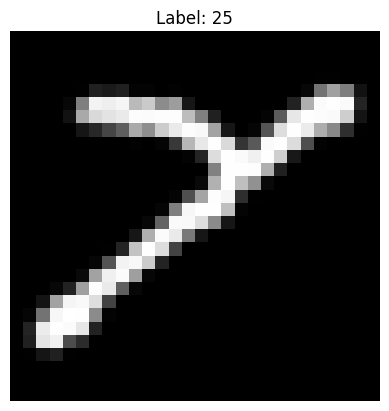

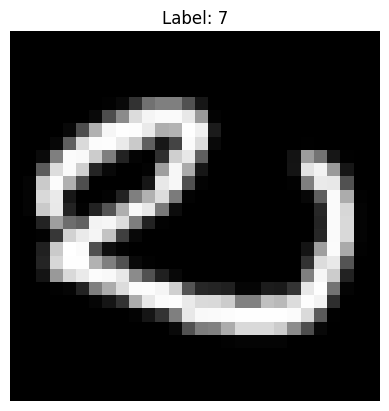

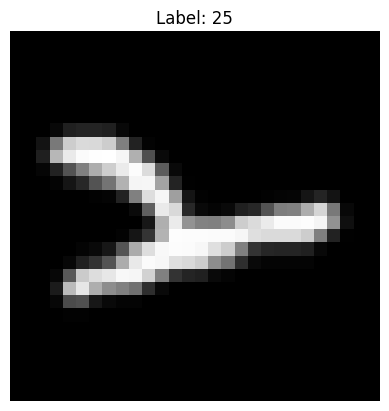

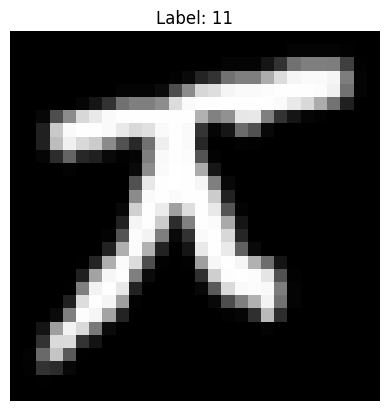

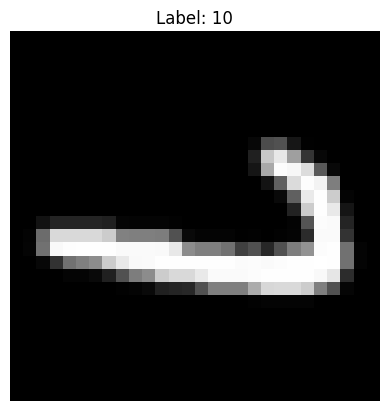

In [63]:
# let's  examine some samples for the dataset

for example, label in dataset.take(5):
    plt.imshow(example.numpy().squeeze(), cmap='gray')
    plt.title(f'Label: {label.numpy()}')
    plt.axis('off')
    plt.show()

In [64]:
# image preprocessing
# As you can see, the images are 90 degree rotated, so we need to spin them back to the original position.
# Also, we need to resize the images to 28x28 and normalize them to [0,1] range. That's why we use the preprocess function below.
def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0  # normalize to [0,1]
    image = tf.transpose(image, perm=[1, 0, 2]) # spin the image to make it (height, width, channels)
    image = tf.image.resize(image, [28, 28])  # resize to 28x28 for CNN input
    return image, label

dataset = dataset.map(preprocess)

logger = TensorBoardLogger('logs/', name='CNN_classifier')# remember to setting up logger variable to store the log model



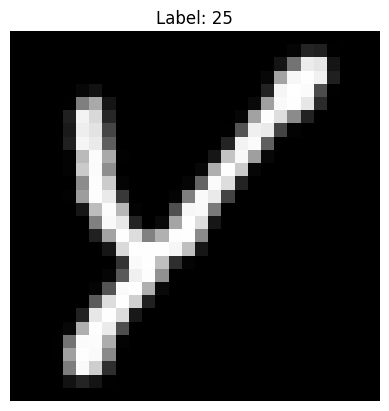

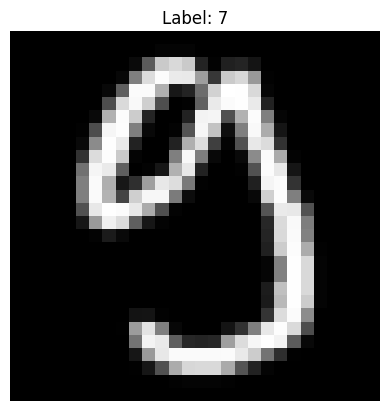

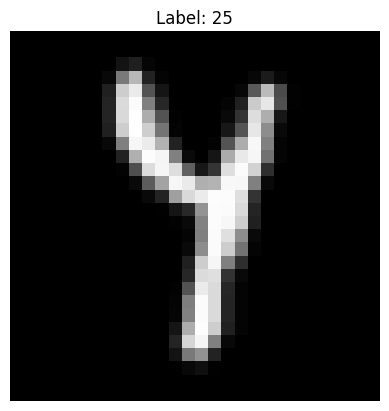

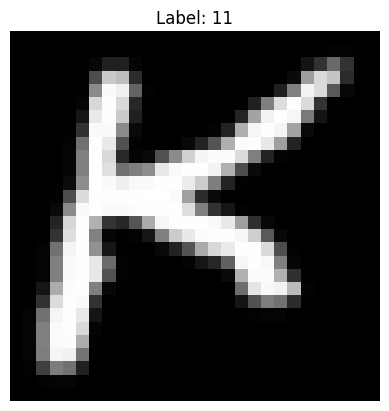

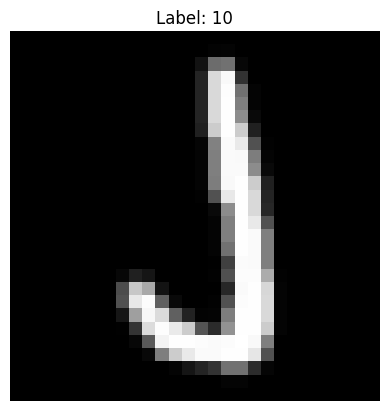

In [65]:
# let's check agein the dataset
for example, label in dataset.take(5):
    plt.imshow(example.numpy().squeeze(), cmap='gray')
    plt.title(f'Label: {label.numpy()}')
    plt.axis('off')
    plt.show()



...Now it looks like they are in good shape -- we can recognize what those letters are! Let's initialize dataloader for training and build up the CNN model then!

In [66]:
# initializing the dataset and dataloader and parameters
batch_size = 32
epochs=10
lr=0.001
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')# use GPU if available
transform= transforms.Compose([
    transforms.ToTensor(),  # convert to tensor
    transforms.Normalize((0.5,), (0.5,))  # normalize to [-1, 1]
])

train_dataset = datasets.EMNIST(root='data', split='letters', train=True, download=True, transform=transform)

test_dataset = datasets.EMNIST(root='data', split='letters', train=False, download=True, transform=transform)

# the original label is from 1 to 26, but we need to make it from 0 to 25 because the label is used as index in the model
train_dataset.targets = train_dataset.targets - 1
test_dataset.targets = test_dataset.targets - 1

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [67]:
class CNNreaderlightning(pl.LightningModule):# be careful with the name, it should be the same as the class name
    def __init__(self):
        super(CNNreaderlightning, self).__init__()
        self.con_layers= nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),#input channel is 1 because the image is grayscale and output channel is 32, knernel size is 3x3, stride is 1, padding is 1
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 26)# 26 classes for English letters
        )
# in the CNN model, I defined the convolutional layers and fully connected layers separately, 
# because the input of the fully connected layer should be 2D tensor, but the output of the convolutional layers is 4D tensor.
# So I need to add a flatten layer to make it 2D tensor.
    def forward(self, x):
        x = self.con_layers(x)
        x = self.fc_layers(x)# NOTE to add the flatten layer here, because the input of the fully connected layer should be 2D tensor
        return x
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = nn.CrossEntropyLoss()(y_hat, y)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_acc', (y_hat.argmax(dim=1) == y).float().mean(), on_step=True, on_epoch=True, prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = nn.CrossEntropyLoss()(y_hat, y)
        self.log('val_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('val_acc', (y_hat.argmax(dim=1) == y).float().mean(), on_step=True, on_epoch=True, prog_bar=True)
        return loss
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=lr)
    
# initializing the model and loss function and optimizer
model = CNNreaderlightning().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

logger = TensorBoardLogger('logs/', name='CNN_classifier') 
# training the model
trainer = pl.Trainer(max_epochs=epochs, accelerator='auto', logger=logger)  # use GPU if available
trainer.fit(model, train_loader, test_loader)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params | Mode 
--------------------------------------------------
0 | con_layers | Sequential | 18.8 K | train
1 | fc_layers  | Sequential | 1.6 M  | train
--------------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.553     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


c:\Users\likua\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Epoch 9: 100%|██████████| 3900/3900 [00:40<00:00, 97.35it/s, v_num=5, train_loss_step=0.134, train_acc_step=0.938, val_loss_step=7.73e-6, val_acc_step=1.000, val_loss_epoch=0.194, val_acc_epoch=0.944, train_loss_epoch=0.116, train_acc_epoch=0.956]     

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 3900/3900 [00:40<00:00, 97.21it/s, v_num=5, train_loss_step=0.134, train_acc_step=0.938, val_loss_step=7.73e-6, val_acc_step=1.000, val_loss_epoch=0.194, val_acc_epoch=0.944, train_loss_epoch=0.116, train_acc_epoch=0.956]


In [42]:
print(os.listdir("logs/CNN_classifier"))
print(os.listdir('logs/CNN_classifier/version_3/checkpoints'))
print("Logs directory:", os.path.abspath('logs/CNN_classifier'))

['version_0', 'version_1', 'version_2', 'version_3', 'version_4']
['epoch=9-step=39000.ckpt']
Logs directory: d:\Applied Deep Learning\logs\CNN_classifier


In this section, I used EMNIST dataset for hand written letter classification: it turns out that there are 14800 samples and the images have been fliped for 90 degrees. After I checked the image, I did the normalization work, fliped them and made them the size of 28 x 28 so that CNN could work with it.

Then, I converted normalized and resized image into tensors and normalized them into the range of [-1,1]. What is more, I also created Tensorboard to log the traning process(recording loss and accuracy) when using lightning.

Then, I splited the tensors into training set and validation set using utils.dataset and dataloader.

For the model build-up, I defined two layers of neural networks: the first one is the CNN itself, the second one is the fully connection layer-- it connects the tensors being processed by CNN into the shape of CrossEntropy loss and conducting the multi-classification task.

For the CNN model itself, I firstly made the channel from 1 to 32, and 32 to 64 to extract more features using 32 convolutional filters and 64 convolutional filters and then, I used pooling to extract the outstanding features after each filter computation. 

The result is: 08.10it/s, v_num=0, train_loss_step=0.263, train_acc_step=0.875, val_loss_step=0.00319, val_acc_step=1.000, val_loss_epoch=0.188, val_acc_epoch=0.940, train_loss_epoch=0.124, train_acc_epoch=0.954 

It shows that in validation step, the accuracy is 0.94, and the loss is 0.188. There is a relatively high accuracy for the classification task, and there is also a small loss -- meaning it is relatively successful for generalization for the classification task.

In [19]:
# training the model
def train(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    return running_loss/len(loader), correct/total

# testing the model
def test(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    return running_loss/len(loader), correct/total



# training loop
train_losses = []
train_accs = []
test_losses = []
test_accs = []

for epoch in range(epochs):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    test_loss, test_acc = test(model, test_loader, criterion)
    
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    
    print(f"Epoch [{epoch+1}/{epochs}] | "
          f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
          f"Test Loss: {test_loss:.4f} Acc: {test_acc:.4f}")



Epoch [1/10] | Train Loss: 0.4654 Acc: 0.8534 | Test Loss: 0.2259 Acc: 0.9266
Epoch [2/10] | Train Loss: 0.2596 Acc: 0.9143 | Test Loss: 0.1956 Acc: 0.9342
Epoch [3/10] | Train Loss: 0.2192 Acc: 0.9264 | Test Loss: 0.1926 Acc: 0.9361
Epoch [4/10] | Train Loss: 0.1912 Acc: 0.9355 | Test Loss: 0.1856 Acc: 0.9376
Epoch [5/10] | Train Loss: 0.1716 Acc: 0.9406 | Test Loss: 0.1877 Acc: 0.9386
Epoch [6/10] | Train Loss: 0.1567 Acc: 0.9445 | Test Loss: 0.1797 Acc: 0.9427
Epoch [7/10] | Train Loss: 0.1439 Acc: 0.9481 | Test Loss: 0.1808 Acc: 0.9423
Epoch [8/10] | Train Loss: 0.1364 Acc: 0.9512 | Test Loss: 0.1851 Acc: 0.9407
Epoch [9/10] | Train Loss: 0.1264 Acc: 0.9533 | Test Loss: 0.1875 Acc: 0.9425
Epoch [10/10] | Train Loss: 0.1191 Acc: 0.9551 | Test Loss: 0.2015 Acc: 0.9417


## Part 3: Comparing Optimizers and Analyzing Training Curves

In this step, you'll experiment with different optimizers—SGD, Adam, and RMSProp—to understand how they affect model performance. You will compare their effects using evaluation metrics on held-out test data and analyze the training and validation curves logged in TensorBoard.

### A. Experiment Setup

1. **Maintain Consistent Training Settings:**  
   - Use the same model architecture (whether FFNN, CNN, or RNN from Parts 1 and 2) and dataset for all experiments.
   - Ensure that the number of epochs, batch size, learning rate, and other hyperparameters are kept constant across different optimizer runs, aside from the optimizer itself.

2. **Implement Optimizer Switching:**  
   - Modify the `configure_optimizers` method in your PyTorch Lightning module to easily switch between optimizers:
     ```python
     def configure_optimizers(self):
         # Uncomment the optimizer you want to use
         # return torch.optim.SGD(self.parameters(), lr=0.01)
         # return torch.optim.Adam(self.parameters(), lr=1e-3)
         # return torch.optim.RMSprop(self.parameters(), lr=1e-3)
     ```
   - Train your model separately with each optimizer.

### B. Evaluation Metrics and Analysis

1. **Held-Out Test Evaluation:**  
   - After training, evaluate each model on a held-out test set.
   - Record quantitative metrics such as loss, accuracy, or any other relevant task-specific metric for each optimizer.

2. **TensorBoard Analysis:**  
   - Use TensorBoard to review the training and validation curves during training.
   - Focus on:
     - **Convergence Behavior:** How quickly does each optimizer reduce the loss?
     - **Stability:** Are there noticeable fluctuations or instability in the curves?
     - **Overfitting/Underfitting:** Do you observe signs of overfitting or underfitting, and how do these behaviors differ across optimizers?

### C. Document Your Findings

- **Summarize Performance:**  
  - Create a table or a brief report comparing the evaluation metrics for SGD, Adam, and RMSProp.
- **Include Visual Evidence:**  
  - Attach TensorBoard screenshots or summaries of the logged training/validation curves.
- **Provide a Comparative Analysis:**  
  - Discuss which optimizer provided the best performance on the test set.
  - Reflect on the convergence rates and stability differences you observed.
  - Explain potential reasons for these differences based on your results.

By the end of this exercise, you will have a deeper understanding of how different optimizers affect model training dynamics and performance. This insight is essential for making informed decisions when tuning models in future projects.

For this part, I set up log for 3 different logs on tensor board to record different optimizer traning situations. 
I set up SGD and RMSprop into different logs so that I can make screen shots in a clear way-- the results are in the report.

In [ ]:
from pytorch_lightning.loggers import TensorBoardLogger

# For SGD
logger_sgd = TensorBoardLogger('logs/', name='rnn_classifier_sgd')

# For Adam
logger_adam = TensorBoardLogger('logs/', name='rnn_classifier_adam')

# For RMSprop
logger_rmsprop = TensorBoardLogger('logs/', name='rnn_classifier_rmsprop')

In [15]:
class RNNClassifierLightning(pl.LightningModule):
    def __init__(self, input_size=768, hidden_size=128, num_classes=2, lr=0.001, optimizer_name='adam'):
        super(RNNClassifierLightning, self).__init__()
        self.model = RNNClassifier(input_size, hidden_size, num_classes)
        self.lr = lr
        self.optimizer_name = optimizer_name  # <- add this line

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = nn.CrossEntropyLoss()(y_hat, y)
        acc = (y_hat.argmax(dim=1) == y).float().mean()
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_acc', acc, on_step=True, on_epoch=True, prog_bar=True)
        self.log('val_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('val_acc', acc, on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def configure_optimizers(self):
        if self.optimizer_name == 'sgd':
            return torch.optim.SGD(self.parameters(), lr=self.lr)
        elif self.optimizer_name == 'rmsprop':
            return torch.optim.RMSprop(self.parameters(), lr=self.lr)
        else:  # default to Adam
            return torch.optim.Adam(self.parameters(), lr=self.lr)

In [16]:
LightningModel = RNNClassifierLightning(optimizer_name='sgd')
trainer = pl.Trainer(max_epochs=20, logger=logger_sgd)
trainer.fit(LightningModel, train_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\likua\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:654: Checkpoint directory logs/rnn_classifier_sgd\version_0\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | RNNClassifier | 460 K  | train
------------------------------------------------
460 K     Trainable params
0         Non-trainable params
460 K     Total params
1.840     Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode
c:\Users\likua\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the

Epoch 19: 100%|██████████| 321/321 [00:04<00:00, 68.62it/s, v_num=0, train_loss_step=0.667, train_acc_step=0.500, val_loss_step=0.667, val_acc_step=0.500, train_loss_epoch=0.546, train_acc_epoch=0.793, val_loss_epoch=0.546, val_acc_epoch=0.793]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 321/321 [00:04<00:00, 68.42it/s, v_num=0, train_loss_step=0.667, train_acc_step=0.500, val_loss_step=0.667, val_acc_step=0.500, train_loss_epoch=0.546, train_acc_epoch=0.793, val_loss_epoch=0.546, val_acc_epoch=0.793]


In [17]:
LightningModel = RNNClassifierLightning(optimizer_name='rmsprop')
trainer = pl.Trainer(max_epochs=20, logger=logger_rmsprop)# DO remember set up different varibale here!
trainer.fit(LightningModel, train_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | RNNClassifier | 460 K  | train
------------------------------------------------
460 K     Trainable params
0         Non-trainable params
460 K     Total params
1.840     Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode


Epoch 19: 100%|██████████| 321/321 [00:08<00:00, 38.30it/s, v_num=0, train_loss_step=0.557, train_acc_step=0.750, val_loss_step=0.557, val_acc_step=0.750, train_loss_epoch=0.384, train_acc_epoch=0.926, val_loss_epoch=0.384, val_acc_epoch=0.926]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 321/321 [00:08<00:00, 38.10it/s, v_num=0, train_loss_step=0.557, train_acc_step=0.750, val_loss_step=0.557, val_acc_step=0.750, train_loss_epoch=0.384, train_acc_epoch=0.926, val_loss_epoch=0.384, val_acc_epoch=0.926]


## Submission Instructions

**What to Submit:**

1. Your complete iPython notebook for Milestone 3 (including all code, outputs, and markdown explanations).
2. A single PDF file that contains your entire report for the milestone, covering:
   - Part 1: Benchmarking FFNN vs. RNN on sequence data.
   - Part 2: (Any additional tasks, if applicable.)
   - Part 3: Comparing optimizers and analyzing training curves.

**How to Submit:**

- Upload both your iPython notebook and the PDF report to Canvas.
- Name your files clearly, for example:
  - `YourName_Milestone3.ipynb`
  - `YourName_Milestone3_Report.pdf`

**Deadline:**

- All submissions are due **4/18/21**.

Happy Deep Learning!